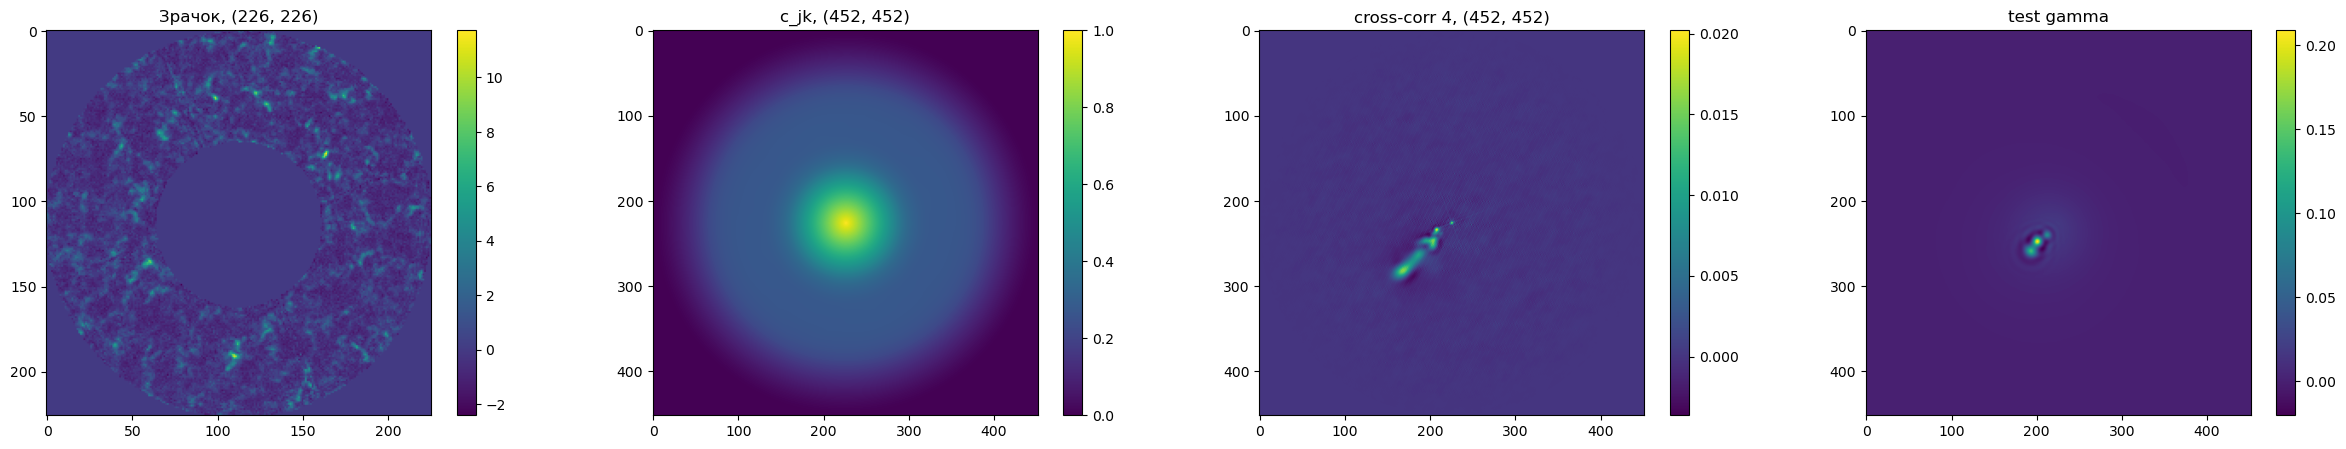

In [122]:
import time
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import shift
from scipy.optimize import curve_fit
from skimage.filters import threshold_multiotsu, threshold_otsu, median

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    
    if idx == (len(array) - 1):
        return idx, idx-1
    if idx == 0:
        return 1, 0
    else:
        if array[idx] > value:
            return idx, idx-1 
        if array[idx] < value:
            return idx+1, idx

def gamma_poly_se(X, Y, Vx, Vy, Cn2, z):
    global cjk, t, a1, gammas, delta
    
    Lx = Vx*t
    Ly = Vy*t
    Xpix = Lx/delta
    Ypix = Ly/delta
    
    lv = find_nearest(a1, z)[1]
    uv = find_nearest(a1, z)[0]
    
    res = gammas[lv] + (z - a1[lv])*((gammas[uv] - gammas[lv])/(a1[uv] - a1[lv]))
    
    res = (res/(1e-13))*Cn2
    res = shift(res, (-Ypix, Xpix), order=1)  

    res = res * cjk
    return res

# ----------- входные параметры
D = 2.5
latency = 4
data_dir = 'D:/astro/domecam'
lambda_=500*pow(10, -9) # нм


sec_per_frame = 0.01
t = sec_per_frame * latency
k = 2*np.pi/lambda_

# ---------- считывание зрачка, картины мерцаний, автокорреляции зрачка и гамм

pupil = np.loadtxt(f'{data_dir}/frame.gz')
data = np.loadtxt(f'{data_dir}/data_corr4.gz')
cjk = np.loadtxt(f'{data_dir}/cjk.gz')
gammas = np.load(f'{data_dir}/gammas.npy')
test_gamma = np.loadtxt(f'{data_dir}/test_gamma.gz')
a1 = np.loadtxt(f'{data_dir}/z.gz')

# ------------ шаг для функции гамма
x = np.linspace(-data.shape[1]//2, data.shape[1]//2-1, data.shape[1])
y = np.linspace(-data.shape[0]//2, data.shape[0]//2-1, data.shape[0])
X, Y = np.meshgrid(x, y)

delta = D/(pupil.shape[0]) # шаг по пикселю

# ------------------ распределение гамм


fig, (ax, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 5))

fig.colorbar(ax.imshow(pupil), ax = ax)
ax.grid(False)
ax.set_title(f'Зрачок, {pupil.shape}')

fig.colorbar(ax2.imshow(cjk), ax=ax2)
ax2.grid(False)
ax2.set_title(f'c_jk, {cjk.shape}')

fig.colorbar(ax3.imshow(data), ax=ax3)
ax3.grid(False)
ax3.set_title(f'cross-corr 4, {data.shape}')

fig.colorbar(ax4.imshow(test_gamma), ax=ax4)
ax4.grid(False)
ax4.set_title(f'test gamma')

def CLEAN(dirty, gain=None, thresh=None, niter=None):
    global t, delta
    st = time.perf_counter()
    comps = np.zeros(dirty.shape)
    res = np.array(dirty) 
    cl = np.zeros(dirty.shape)
    
    tmp = 0
    tmp_Vx = []
    tmp_Vy = []
    all_params = []
    for i in range(niter):
        my, mx = np.unravel_index(np.argmax(res), res.shape)
        mval=res[my, mx]*gain
        comps[my, mx]+=mval
        
        Vy = (dirty.shape[0]//2-my)*delta/t
        Vx = -(dirty.shape[1]//2-mx)*delta/t
        
        tmp_Vx.append(Vx)
        tmp_Vy.append(Vy)
                
        if i > 5\
        and tmp_Vx[i-4] == tmp_Vx[i] and tmp_Vx[i-3] == tmp_Vx[i] and tmp_Vx[i-2] == tmp_Vx[i] and tmp_Vx[i-1] == tmp_Vx[i]\
        and tmp_Vy[i-4] == tmp_Vy[i] and tmp_Vy[i-3] == tmp_Vy[i] and tmp_Vy[i-2] == tmp_Vy[i] and tmp_Vy[i-1] == tmp_Vy[i]:
            print('Stucked')
            break
        
        if int(Vx) == 0 and int(Vy) == 0:
            myParams = [0, 0, 1e-13, 2000]
            psf, params = multi_speckle_fit(myParams, ydata=res)
            print('test', np.max(psf))
            print('-initial value:', res[my, mx])
            res -= psf*0.9
        else:
            myParams = [Vx, Vy, 1e-13, 15000+5000*np.sin(np.random.uniform(-np.pi, np.pi))]  
            psf, params = multi_speckle_fit(myParams, ydata=res)
            print('-initial value:', res[my, mx])
            res -= psf*gain
        
        cl += psf*gain
        all_params.append(params)
        print('-residual value:', res[my, mx])
        print(' ')
    
        tmp = i
        if np.max(res) < thresh:
            print('Thresh reached!')
            break
    print('Total iterations:', tmp+1)
    print('time:', time.perf_counter()-st)
    return comps, res, cl, np.array(all_params)


def multi_speckle_fit(params, ydata=None):
    global data, t, delta, X, Y
    st=time.perf_counter()  
    def speckle_fit(params, ydata):
        xdata = np.vstack((X.ravel(), Y.ravel()))
        fit = np.zeros(X.shape)
#         z_log = 5*np.logspace(0, 4, num=100, base=10.0, dtype=int)
        def _g(one_dim_x, *args): 
            arr = np.zeros(one_dim_x[0].shape)
            Vx = args[0]
            Vy = args[1]
            Cn2 = args[2]
            z = args[3]
#             z = z_log[find_nearest(z_log, args[3])[0]]
            arr += gamma_poly_se(one_dim_x[0], one_dim_x[1], Vx, Vy, Cn2, z).ravel()
            return arr
        
        
        ydata = ydata.ravel()

        bounds = [[params[0]-3, params[1]-3, -np.inf, 2000], [params[0]+3, params[1]+3, np.inf, 50000]]
        popt, pcov = curve_fit(_g, xdata, ydata, p0=params, bounds=bounds) 
        
        fit += gamma_poly_se(X, Y, *popt)          
        return fit, popt[0], popt[1], popt[2], popt[3]
        
    res = np.zeros(data.shape)
    print(f'Speckle fitting:', *params)
    fit, Vx, Vy, Cn2, z = speckle_fit(params, ydata)
    res +=fit
        
    Lx = Vx*t
    Ly = Vy*t
    Xpix = Lx/delta
    Ypix = Ly/delta
    print(f'Fitted parametrs: {Vx:.2f} {Vy:.2f} {Cn2} {z}')
    print('time:', time.perf_counter()-st)    
    return res, [Vx, Vy, Cn2, z]

def one_speckle_fit(params=None, data=None): 
    def _g(M, *args): 
        x, y = M
        arr = np.zeros(x.shape)
        for i in range(len(args)//4):
            arr += gamma_poly_se(x, y, *args[i*4:i*4+4]).ravel()
        return arr
        
    p0 = [p for prms in params for p in prms]
        
    st=time.perf_counter()
       
    x = np.linspace(-data.shape[1]//2, data.shape[1]//2-1, data.shape[1])
    y = np.linspace(-data.shape[0]//2, data.shape[0]//2-1, data.shape[0])
    X, Y = np.meshgrid(x, y)

    fit = np.zeros(X.shape) 
    xdata = np.vstack((X.ravel(), Y.ravel())) 
    ydata = data.ravel()
        
    lb = [-np.inf, -np.inf, -np.inf, 2000]
    lb = np.tile(lb, len(p0)//4)
    ub = [np.inf, np.inf, np.inf, 50000]
    ub = np.tile(ub, len(p0)//4)
        
    popt, pcov = curve_fit(_g, xdata, ydata, p0, bounds=[lb, ub])

    for i in range(len(popt)//4):
        fit += gamma_poly_se(X, Y, *popt[i*4:i*4+4])

    print(f'Time: {time.perf_counter()-st:.4f}')

    for i in range(len(popt)//4):
        print(*popt[i*4:i*4+4])

    return fit, popt

Speckle fitting: 0 0 1e-13 2000
Fitted parametrs: 0.01 0.05 1.2092002511537366e-13 2199.982053252578
time: 0.8289947999992364
test 0.016587564236894926
-initial value: 0.020219190046191216
-residual value: 0.005290382232985781
 
Speckle fitting: -4.977876106194691 -2.2123893805309733 1e-13 11474.303077831148
Fitted parametrs: -4.98 -2.21 2.457668045207542e-14 11474.303077831148
time: 0.12946280000051047
-initial value: 0.019702743782590754
-residual value: 0.013549640332737603
 
Speckle fitting: -15.763274336283187 -15.486725663716813 1e-13 15902.394158116835
Fitted parametrs: -15.90 -15.33 2.4019001867021993e-14 47851.8825606416
time: 0.5820598999998765
-initial value: 0.016244074227191523
-residual value: 0.008710225419788237
 
Speckle fitting: -6.084070796460177 -6.084070796460177 1e-13 13602.301988597601
Fitted parametrs: -6.65 -6.17 1.3963670274313537e-14 32469.952309114255
time: 0.7318573000002289
-initial value: 0.01623031405175166
-residual value: 0.009799198128033988
 
Speckle

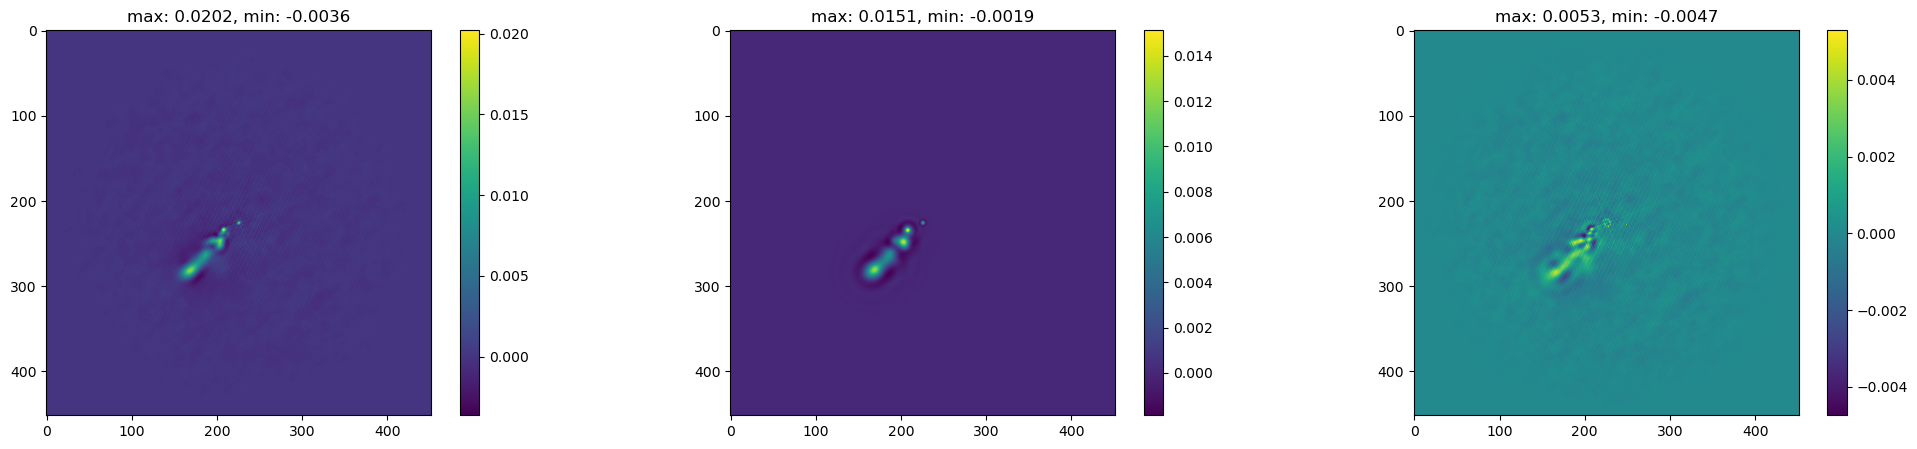

In [128]:
comps, residual, clean, params = CLEAN(data, gain=0.5, thresh=threshold_otsu(data), niter=100)

fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5)) 
fig.colorbar(ax.imshow(data), ax=ax) 
fig.colorbar(ax2.imshow(clean), ax=ax2) 
fig.colorbar(ax3.imshow(residual), ax=ax3) 
ax.set_title(f'max: {np.max(data):.4f}, min: {np.min(data):.4f}') 
ax2.set_title(f'max: {np.max(clean):.4f}, min: {np.min(clean):.4f}') 
ax3.set_title(f'max: {np.max(residual):.4f}, min: {np.min(residual):.4f}')
print('')

initial params: (24, 4) 
cleaned params: (17, 4)
[[-1.70000000e+01 -1.60000000e+01  1.41831118e-14  3.66360000e+04]
 [-1.50000000e+01 -1.50000000e+01  2.40190019e-14  4.78510000e+04]
 [-1.50000000e+01 -1.40000000e+01  1.76116279e-14  3.62380000e+04]
 [-1.30000000e+01 -1.30000000e+01  9.11588747e-15  3.88160000e+04]
 [-1.20000000e+01 -1.10000000e+01  1.20834629e-14  4.99700000e+04]
 [-1.00000000e+01 -1.00000000e+01  6.30681318e-15  4.99110000e+04]
 [-1.00000000e+01 -9.00000000e+00  1.03488377e-14  1.86030000e+04]
 [-9.00000000e+00 -5.00000000e+00  1.61121462e-14  1.20950000e+04]
 [-7.00000000e+00 -6.00000000e+00  4.52965291e-15  4.99800000e+04]
 [-6.00000000e+00 -6.00000000e+00  1.43636360e-14  2.28215000e+04]
 [-5.00000000e+00 -7.00000000e+00  1.19794466e-14  1.02460000e+04]
 [-5.00000000e+00 -5.00000000e+00  3.86632858e-15  1.99470000e+04]
 [-5.00000000e+00 -3.00000000e+00  4.05370183e-15  1.98670000e+04]
 [-4.00000000e+00 -2.00000000e+00  3.67268226e-14  9.41133333e+03]
 [-4.00000000

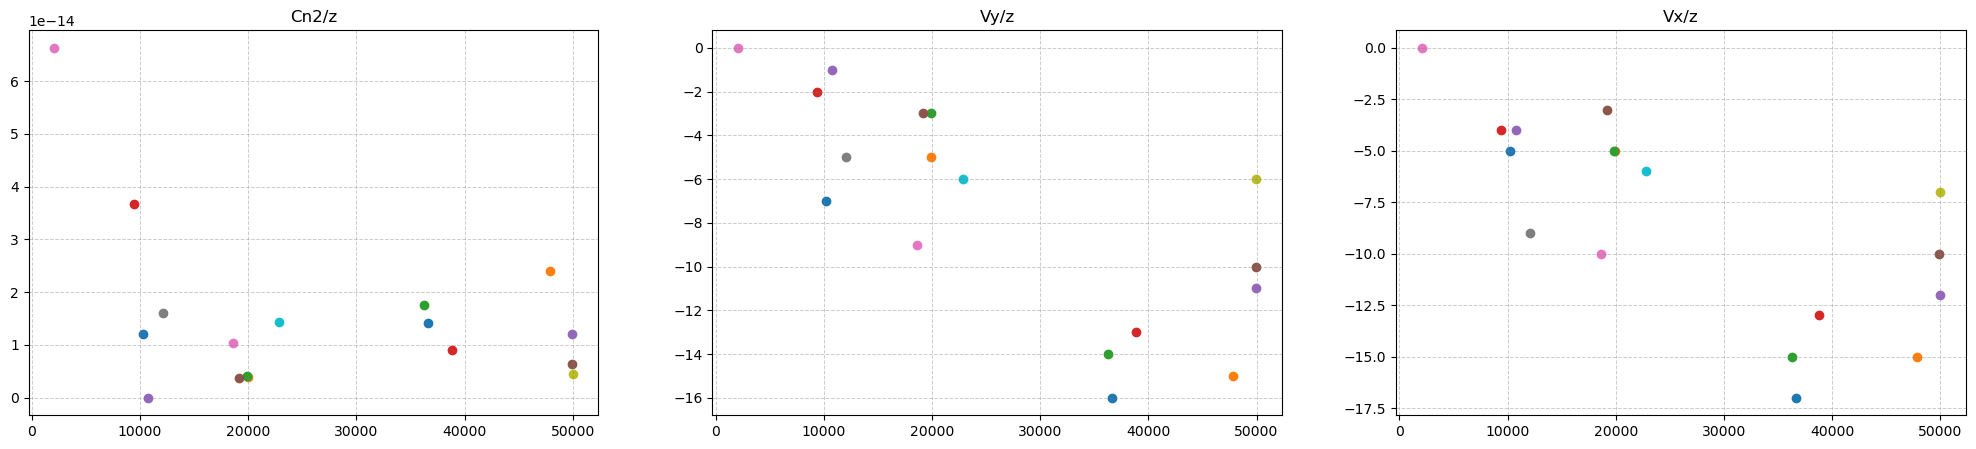

In [299]:
params
new_params = params.copy()

new_params[:, 0] = np.vectorize(int)(new_params[:, 0])
new_params[:, 1] = np.vectorize(int)(new_params[:, 1])
new_params[:, 3] = np.vectorize(int)(new_params[:, 3])

new_params2 = []
for i in range(new_params.shape[0]):
    vx = new_params[i][0]
    vy = new_params[i][1]
#     print('main:', vx, vy)
    tmp=[]
    for j in range(new_params.shape[0]):
        if vx == new_params[j][0] and vy == new_params[j][1]:
#             print('found:', new_params[j])
            tmp.append(new_params[j])
    tmp = np.array(tmp)
#     print('merge:\n', tmp)
#     print('mean:', np.mean(tmp, axis=0))
    new_params2.append(np.mean(tmp, axis=0))
    del tmp
    
new_params2 = np.unique(np.array(new_params2), axis=0)
print('initial params:', new_params.shape, '\ncleaned params:', new_params2.shape)
print(new_params2)

fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5)) 
for i in new_params2:
    ax.scatter(i[3], i[2])
    ax2.scatter(i[3], i[1])
    ax3.scatter(i[3], i[0])
ax.set_title('Cn2/z')
ax2.set_title('Vy/z')
ax3.set_title('Vx/z')
ax.grid(color='grey', linestyle='--', linewidth=0.7, alpha=0.4)
ax2.grid(color='grey', linestyle='--', linewidth=0.7, alpha=0.4)
ax3.grid(color='grey', linestyle='--', linewidth=0.7, alpha=0.4)

Time: 104.3547
0.015850194324276427 0.049977295029062375 1.194617741977901e-13 2206.257410572194
-4.424773110251441 -3.3010238250446013 -3.589675867856081e-14 12378.475148977888
-18.20416982505334 -16.797512693045128 9.741051287082335e-15 47475.096813359596
-6.41402116028298 -7.35739141488096 8.617278111581952e-15 32342.76001139724
-4.585448822892248 -3.2560896286676115 4.562892118146602e-14 14625.96877141125
-13.541307241868884 -13.184569135180272 1.4764148983491977e-14 48527.54612023167
-4.935563220178729 -2.199838072963739 9.129677066540183e-14 3218.5611251471473
-8.575106250892642 -9.122036894009025 -2.060255637200269e-15 49922.452477476494
-15.96923418288419 -15.543645098044031 2.789482459179543e-14 35648.46889751458
-6.4169445850401186 -5.8903397215790925 3.14378534113859e-14 14485.101579816928
-10.149817318712401 -10.105726552005931 1.0676228639827625e-14 49941.40918738564
-9.030766980265563 -5.723475872342209 2.932368204924971e-14 11701.68146365088


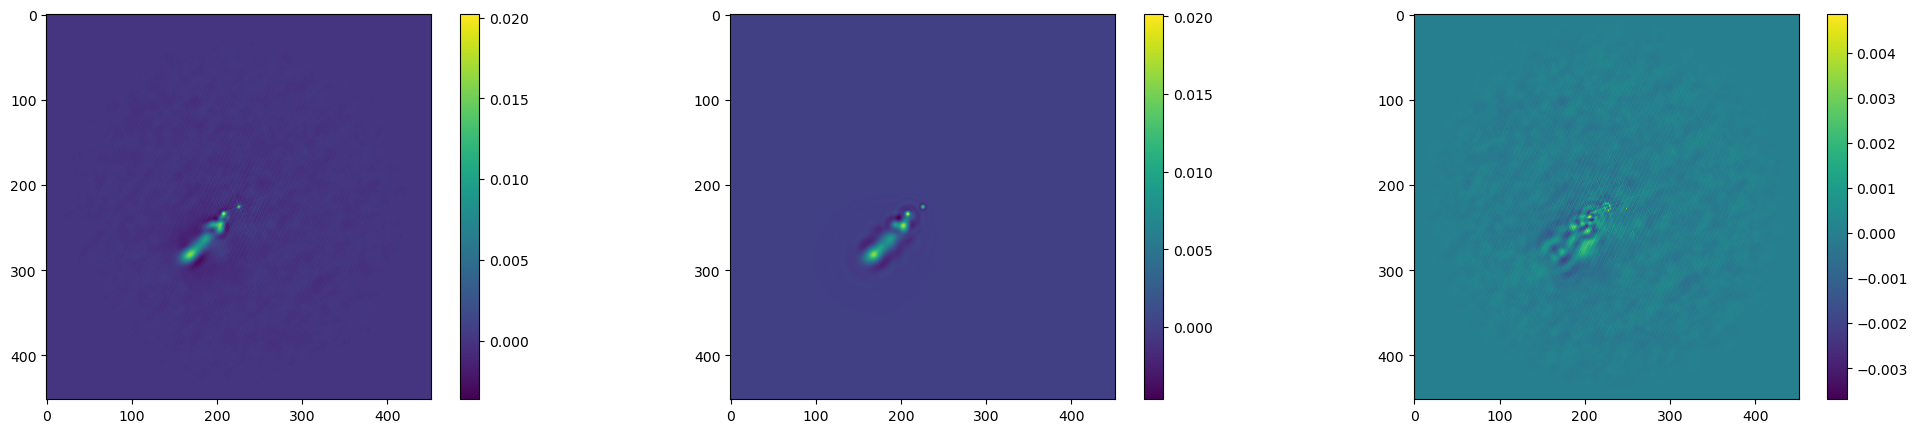

In [135]:
# params
fit, params2 = one_speckle_fit(params[0:12, :], data)

fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5)) 
fig.colorbar(ax.imshow(data), ax=ax) 
fig.colorbar(ax2.imshow(fit), ax=ax2) 
fig.colorbar(ax3.imshow(data-fit), ax=ax3) 

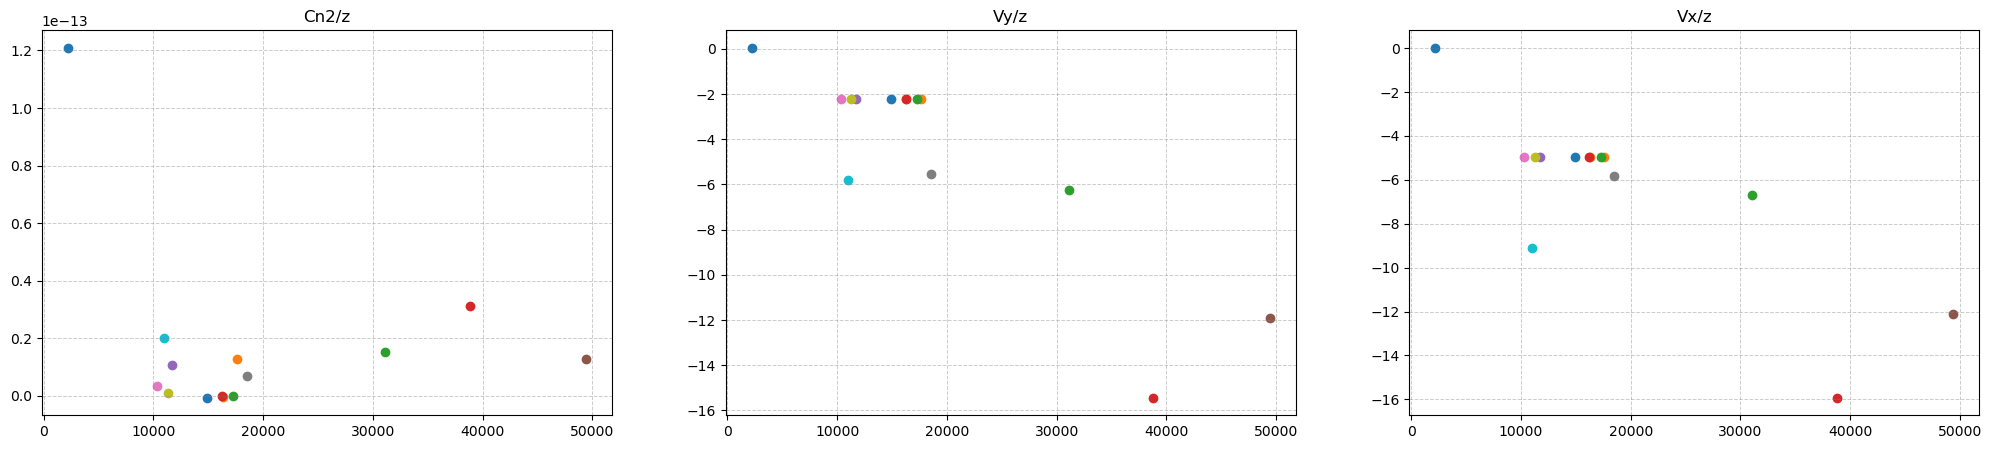

In [85]:
fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5)) 
for i in params:
    ax.scatter(i[3], i[2])
    ax2.scatter(i[3], i[1])
    ax3.scatter(i[3], i[0])
ax.set_title('Cn2/z')
ax2.set_title('Vy/z')
ax3.set_title('Vx/z')
ax.grid(color='grey', linestyle='--', linewidth=0.7, alpha=0.4)
ax2.grid(color='grey', linestyle='--', linewidth=0.7, alpha=0.4)
ax3.grid(color='grey', linestyle='--', linewidth=0.7, alpha=0.4)